# Question 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot, normaltest

# sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [2]:
# Import data into a pandas data frame
ale_data = pd.read_csv('mcs_ds_edited_iter_shuffled.csv')
ale_data.head() # first few rows

,anchor_ratio,trans_range,node_density,iterations,ale,sd_ale
0,30,15,200,40,0.773546,0.250555
1,15,15,100,70,0.911941,0.498329
2,30,15,100,50,0.814867,0.255546
3,15,20,100,20,1.435332,0.394603
4,30,15,100,40,1.265909,0.302943


In [3]:
# Split into features and labels
feature_cols = ["anchor_ratio", "trans_range", "node_density", "iterations"]
label = ["ale"]
x, y = ale_data[feature_cols], ale_data[label]

# MODEL 1: LINEAR

In [4]:
linear_model = LinearRegression()

# Train the model
linear_model.fit(x, y)

# Evaluate the model over the whole dataset
y_pred = linear_model.predict(x)

# Find the residuals
residuals_linear = y_pred - y

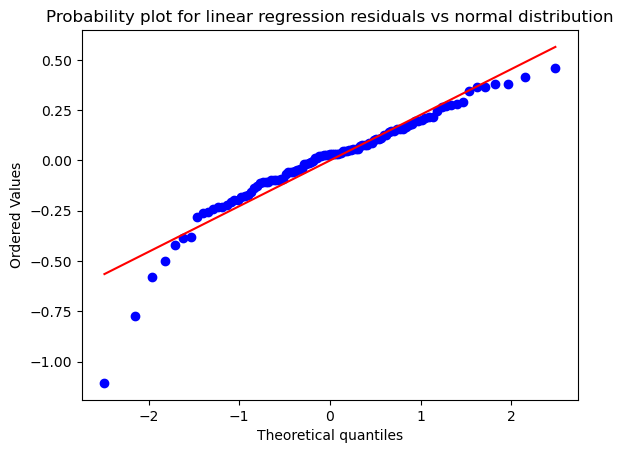

In [5]:
# Probability plot
probplot(residuals_linear['ale'], dist="norm", plot=plt)
plt.title("Probability plot for linear regression residuals vs normal distribution")
plt.show()

In [6]:
# Normality Test
z, p = normaltest(residuals_linear['ale'])
if p < 0.05:
    print(f"The p value is: {p}")
    print("The p value is less than 0.05 so we reject the null hypothesis that the residuals are normally distributed.")

The p value is: 1.2866767006283722e-09
The p value is less than 0.05 so we reject the null hypothesis that the residuals are normally distributed.


## MODEL 2: Neural Network (Multi-Layer Percepteron)

In [7]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

# Specify the model
regr = MLPRegressor(hidden_layer_sizes=10, activation='tanh', solver='lbfgs', max_iter=1000, learning_rate_init=0.001)

# Train the model
regr.fit(X_train, y_train.values.ravel())

# Apply the model to the whole dataset
y_pred_MLP = regr.predict(x)

# Find the residuals
residuals_MLP = y_pred_MLP - np.array(y).T[0]

# Evaluate the model performance on the test dataset (the mean accuracy on the test dataset)
regr.score(X_test, y_test)

-0.15417540042541877

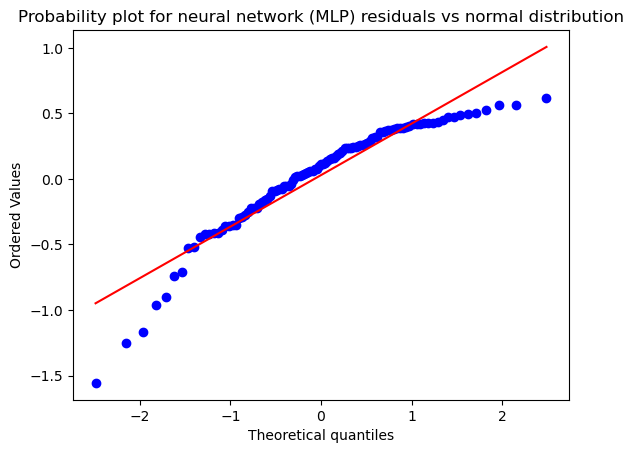

In [8]:
# Probability plot
probplot(residuals_MLP, dist="norm", plot=plt)
plt.title("Probability plot for neural network (MLP) residuals vs normal distribution")
plt.show()

In [9]:
# Normality test
z, p = normaltest(residuals_MLP)
if p < 0.05:
    print(f"The p value is: {p}")
    print("The p value is less than 0.05 so we reject the null hypothesis that the residuals are normally distributed.")

The p value is: 1.7497001133444384e-07
The p value is less than 0.05 so we reject the null hypothesis that the residuals are normally distributed.


So we have seen that in both these models, which use the mean square error loss, the p value is statistically significant enough such that we can reject the null hypothesis.

That is to say, there is sufficient evidence to suggest that the residuals are not normally distributed.

And so, at least with this particular dataset, this specific justification for using mean squared error loss does not hold.